Import the necessary packages for data analysis.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Load the data and have a first glance at it.

In [14]:
try:
    csv_path = "../COVID19-modelling/data/covid_pol_voivodeship.csv"
    load_csv = pd.read_csv(csv_path)
    print("The data was loaded correctly")
except NameError:
    print("The path", csv_path, "cannot be found")

load_csv

The data was loaded correctly


,Date (CET),Lower Silesia (DS),Kuyavia-Pomerania (KP),Lubusz (LB),Łódź (LD),Lublin (LU),Lesser Poland (MA),Masovia (MZ; Warsaw),Opole (OP),Podlaskie (PD),Subcarpathian (PK),Pomerania (PM),Holy Cross (SK),Silesia (SL),Warmia–Masuria (WN),Greater Poland (WP),West Pomerania (ZP),Poland daily,Poland total,Sources
0,4 March 2020,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,[714]
1,5 March 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN
2,6 March 2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2,4,5,[715]
3,7 March 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,6,[17]
4,8 March 2020,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,5,11,[19][22]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,27 August 2020,28,24,12,47,14,233,107,16,12,33,71,18,118,51,92,11,887,64 689,[829]
177,28 August 2020,30,38,9,39,27,139,130,15,5,70,42,19,104,22,92,10,791,65 480,[830]
178,Infections per voivodeship,3995,1268,660,5196,1484,7128,9108,1603,1262,2331,2371,1380,20236,857,5505,1096,NaN,65 480,NaN
179,Date (CET),Lower Silesia (DS),Kuyavia-Pomerania (KP),Lubusz (LB),Łódź (LD),Lublin (LU),Lesser Poland (MA),Masovia (MZ; Warsaw),Opole (OP),Podlaskie (PD),Subcarpathian (PK),Pomerania (PM),Holy Cross (SK),Silesia (SL),Warmia–Masuria (WN),Greater Poland (WP),West Pomerania (ZP),Poland daily,Poland total,Sources


## Reorganize and clean the data. Prepare it for an analysis.

In [15]:
lesser_pol_data = [load_csv["Date (CET)"], load_csv["Lesser Poland (MA)"]]
headers = ["Date", "Number of infections in Lesser Poland"]

df3 = pd.concat(lesser_pol_data, axis=1, keys=headers)

df4 = df3.drop([180, 179, 178])
df4


,Date,Number of infections in Lesser Poland
0,4 March 2020,NaN
1,5 March 2020,NaN
2,6 March 2020,NaN
3,7 March 2020,NaN
4,8 March 2020,NaN
...,...,...
173,24 August 2020,61
174,25 August 2020,141
175,26 August 2020,118
176,27 August 2020,233


Get rid of NaNs

In [16]:
df5 = df4.replace(np.nan, 0)
df5



,Date,Number of infections in Lesser Poland
0,4 March 2020,0
1,5 March 2020,0
2,6 March 2020,0
3,7 March 2020,0
4,8 March 2020,0
...,...,...
173,24 August 2020,61
174,25 August 2020,141
175,26 August 2020,118
176,27 August 2020,233


Convert date to numerical form.

In [17]:
date_elements = []
infected = []
for row in df5.itertuples(index=False):
    #print(row[0])
    date_elements.append(row[0].split())

# date elem has 178 records

for infections in df5.itertuples(index=False):
    infected.append(int(infections[1]))

t = np.linspace(0, len(date_elements), len(date_elements), endpoint=False)

# infected




In [18]:
import  seaborn as sns
sns.set(style="darkgrid")

In [19]:
df5["Number of infections in Lesser Poland"].astype(int)
df5.info()
df5['Days'] = df5.index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Date                                   178 non-null    object
 1   Number of infections in Lesser Poland  178 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


<Figure size 720x720 with 0 Axes>

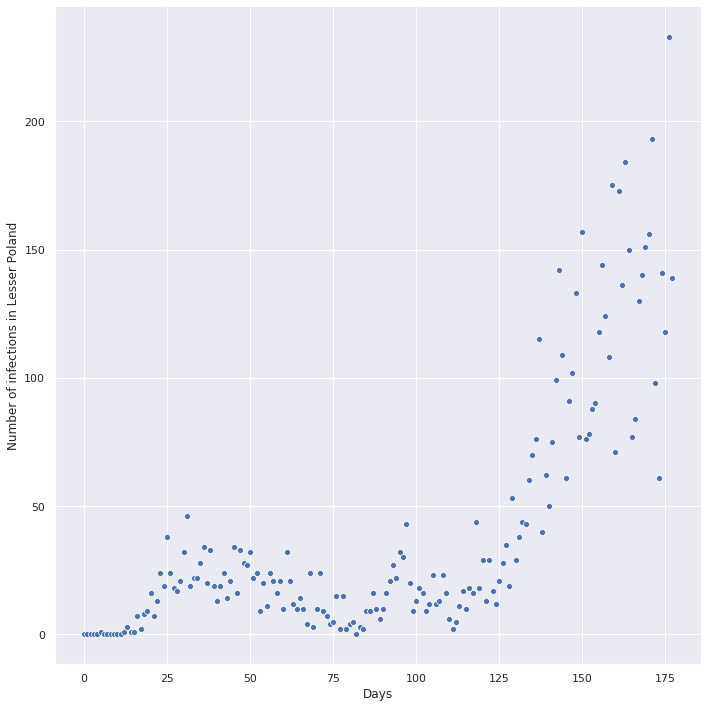

In [20]:
plt.figure(figsize=(10,10))
sns.relplot(x="Days", y="Number of infections in Lesser Poland", data= df5, height=10)

Same length


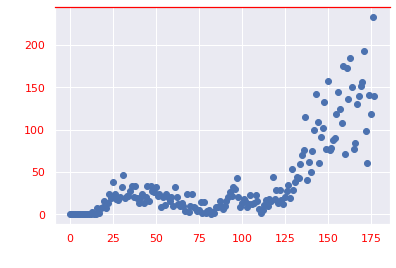

In [21]:
t

if len(t) == len(infected):
    print("Same length")


fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel("Days passed")
ax.set_ylabel("Infected people")

ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("red")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')



ax.scatter(t, infected)
plt.show()

We'll try to predict the future using exponential and logistic function.

In [31]:
def exp_fun(x, a, b, c, C):
    return (a * np.exp((b * x) + c)) + C

def poly(x, a, b, c, d):
    return a * np.power(x, 3) + b * np.power(x, 2) + c * x + d


def fit_fun(X, y, fitted_fun, calls, plot=True):
    test = [1, 1, 1, 1]
    popt, pcov = scipy.optimize.curve_fit(fitted_fun, X, y, maxfev=calls)
    plt.plot(X, y, ".", label="Observations")
    y_fit = fitted_fun(X, *popt)
    R2 = r2_score(y, y_fit)
    print(f"Coefficient of determination: {R2}")
    if plot:
        plt.plot(X, y_fit, 'r-')
        plt.legend()
        plt.show()
    #return popt, pcov, y_fit, R2

Coefficient of determination: 0.7736392445688678


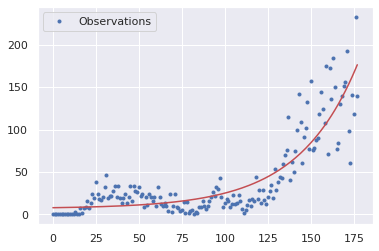

In [30]:

fit_fun(t, infected, exp_fun, 1000000)